# Restricted Boltzmann Machine using quantum annealing on D-wave's QPU

## Imports

In [1]:
import numpy as np
import timeit
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from qrbm.MSQRBM import MSQRBM
from qrbm.classicalRBM import classicalRBM


import matplotlib.pyplot as plt
%matplotlib inline   
plt.rcParams['image.cmap'] = 'gray'

import pandas as pd

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import img_as_bool

import cv2 as cv

import random

## Presets

Here you can set hyperparameters for learning:

 - digits: list of digits to train on
 - THRESHOLD: how bright parts of image become 1 (darker become 0)
 - n_hidden: number of neurons in hidden layer
 - qpu: whether to use real D-wave's qpu (requires [setup](https://docs.ocean.dwavesys.com/en/stable/overview/sapi.html)) or a local simulator
 - epochs: number of epochs
 - lr: learning rate


In [2]:
image_height = 28
image_width = 28

# images will be flattened
len_x = image_height * image_width
len_y = 0

digits = [0, 1]
THRESHOLD = 100
n_hidden = 30
qpu = False
epochs = 1000
lr = 0.1

## reading dataset

In [3]:
mnist_dataset = pd.read_csv('./data/mnist_train.csv')
mnist_test = pd.read_csv('./data/mnist_test.csv')

## prepare train and test set

In [4]:
X_train = mnist_dataset.values[:,1:]
X_train2 = mnist_dataset.values[:,:]

X_test = mnist_test.values[:,1:]
X_test2 = mnist_test.values[:,:]

# print(mnist_dataset.values[:,0])
X_train3 = []
X_test3 = []

for digit in digits:
    X_train3.append(mnist_dataset.values[np.where(mnist_dataset.values[:,0] == digit), 1:][0])
    X_test3.append(mnist_test.values[np.where(mnist_test.values[:,0] == digit), 1:][0])
# X_train3 = mnist_dataset.values[np.where(mnist_dataset.values[:,0] == 0), 1:]


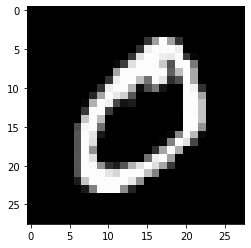

In [5]:
imgs = []
imgs_test = []
for digit_index in range(len(digits)):
    imgs.append(np.resize(X_train3[digit_index], (len(X_train3[digit_index]), 28, 28)) / 255)
    imgs_test.append(np.resize(X_test3[digit_index], (len(X_test3[digit_index]), 28, 28)) / 255)
    
plt.imshow(imgs[0][0])
plt.show()

## resizing images

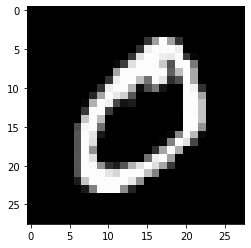

In [6]:
images_resized = []
images_resized_test = []
for digit_index in range(len(digits)):
    images_resized.append([resize(img, (image_width, image_height), anti_aliasing=True) for img in imgs[digit_index]])
    images_resized_test.append([resize(img, (image_width, image_height), anti_aliasing=True) for img in imgs_test[digit_index]])

    # images_resized = [resize(img, (image_width, image_height), anti_aliasing=True) for img in imgs]

plt.imshow(images_resized[0][0])
plt.show()


## normalizing images

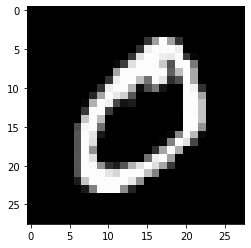

In [7]:
images_normalized = []
images_normalized_test = []

for digit_index in range(len(digits)):
    images_normalized.append([cv.normalize(image_resized, image_resized, 0, 255, cv.NORM_MINMAX) for image_resized in images_resized[digit_index]])
    images_normalized_test.append([cv.normalize(image_resized, image_resized, 0, 255, cv.NORM_MINMAX) for image_resized in images_resized_test[digit_index]])

    # images_normalized = [cv.normalize(image_resized, image_resized, 0, 255, cv.NORM_MINMAX) for image_resized in images_resized]

plt.imshow(images_normalized[0][0])
plt.show()

## converting to binary

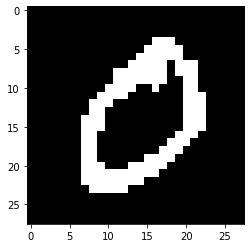

In [8]:
data = []
data_test = []
for digit_index in range(len(digits)):
    data.append([np.where(image_resized > THRESHOLD, 1, 0) for image_resized in images_resized[digit_index]])
    data_test.append([np.where(image_resized > THRESHOLD, 1, 0) for image_resized in images_resized_test[digit_index]])
    
# data = [np.where(image_resized > THRESHOLD, 1, 0) for image_resized in images_resized]

plt.imshow(data[0][0])
plt.show()


## flattening the image

In [9]:
input_data = []
input_data_test = []
for digit_index in range(len(digits)):
    input_data.append([x.flatten().tolist() for x in data[digit_index]])
    input_data_test.append([x.flatten().tolist() for x in data_test[digit_index]])
    
print(input_data[0][0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 

In [10]:
result_picture_tab = []
for digit_index in range(len(digits)):
    result_picture_tab.append(np.mean(input_data_test[digit_index], axis = 0))

## shuffling the training data

In [11]:
for digit in digits:
    flat_input_data = [item for sublist in input_data for item in sublist]
    flat_input_data_test = [item for sublist in input_data_test for item in sublist]

random.shuffle(flat_input_data)
random.shuffle(flat_input_data_test)

## training

In [12]:
bm = MSQRBM(n_visible=len_x, n_hidden=n_hidden, qpu=qpu)
bm.image_height = image_height
bm.tqdm = tqdm
bm.result_picture_tab = result_picture_tab

  0%|          | 0/1000 [00:00<?, ?it/s]

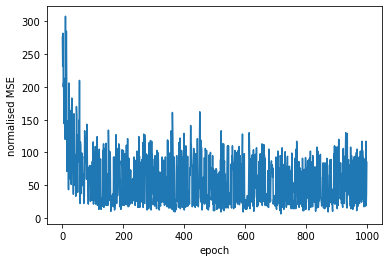

In [13]:
bm.train(flat_input_data, len_x, len_y, epochs = epochs, lr = lr, lr_decay = 0.1)

### See random sampling results

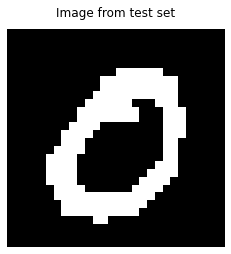

eval:  63.79137130362349


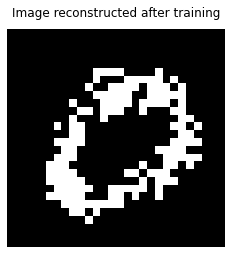

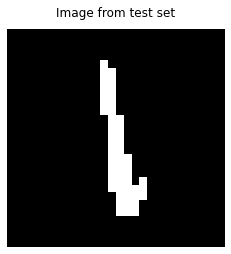

eval:  41.41975353684333


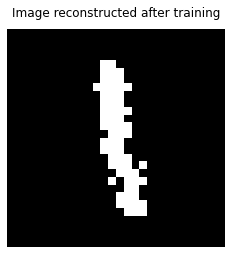

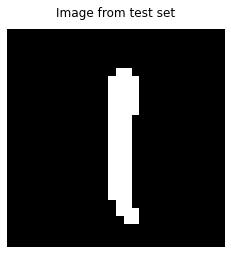

eval:  26.30169186283452


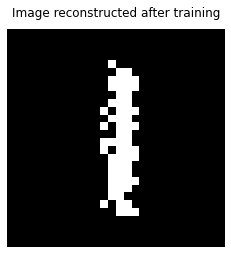

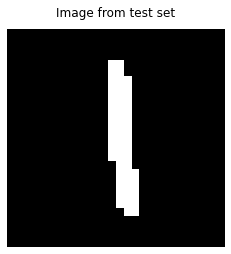

eval:  27.94486366900192


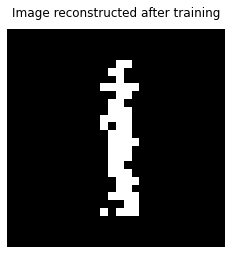

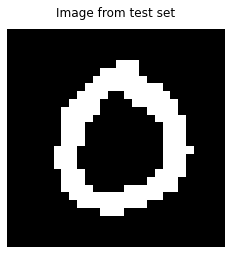

eval:  78.94851416076634


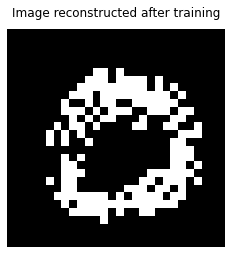

In [14]:
for test in range(5):
    flat_input_data_test_img = np.reshape(flat_input_data_test[test], (image_width, image_height))
    plt.figure()
    plt.axis('off')
    plt.title("Image from test set", y=1.03)
    plt.imshow(flat_input_data_test_img)
    plt.show()
    
    generated_pic = bm.generate(test_img = flat_input_data_test[test])
    evalutation = bm.evaluate(generated_pic, flat_input_data_test[test])
    print("evaluation: ", evaluation)
#     print(generated_pic)
    plt.figure()
    plt.axis('off')
    plt.title("Image reconstructed after training", y=1.03)
    plt.imshow(np.array(generated_pic).reshape(image_height, -1))